## DeepLabV1

### Library

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sys
warnings.filterwarnings("ignore")
sys.path.append("../")

from src.segtool.config import DataConfig, TrainConfig
from src.segtool.data import (
    make_loaders,
    DefectSegDataset,
    DatasetPaths,
    default_paths,
    find_mask
)
from src.segtool.model import DeepLabv1
from src.segtool.models_factory import build_model
from src.segtool.losses import BCEDiceLoss, DiceLoss
from src.segtool.engine import (
    train_one_epoch,
    validate,
    EpochResult,
    _defect_only_metrics
)
from src.segtool.metrics import compute_metrics, reduce_mean, Metrics
from src.segtool.utils import *

In [2]:
set_seed(42)
device = get_device()
print(device)

mps


### Data Load

In [3]:
# Colab root
# dataset_root = "/content/drive/MyDrive/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect"
# Local root
dataset_root = "/Users/mungughyeon/Library/CloudStorage/GoogleDrive-moonstalker9010@gmail.com/내 드라이브/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect"

base_path = Path(dataset_root)
train_loader, val_loader, test_loader = make_loaders(
    base_path=base_path,
    img_size_hw=(144, 256),  # (height, width)
    train_ratio=0.7,
    test_ratio=0.15,
    seed=42,
    batch_size=8, # mps
    num_workers=2
)

print(f"Train: {len(train_loader.dataset)}")
print(f"Val: {len(val_loader.dataset)}")
print(f"Test: {len(test_loader.dataset)}")

Train: 840
Val: 180
Test: 180


In [4]:
deeplabv1_model = DeepLabv1(
    in_channels=3,
    out_channels=1,
    base_channels=32,
    # dropout=0.1
).to(device)

v1_total_params = sum(p.numel() for p in deeplabv1_model.parameters())
v1_trainable_params = sum(p.numel() for p in deeplabv1_model.parameters() if p.requires_grad)
print(f"Total parameters: {v1_total_params:,}")
print(f"Trainable parameters: {v1_trainable_params:,}")

Total parameters: 139,489
Trainable parameters: 139,489


In [5]:
# optimizer
optimizer = torch.optim.Adam(
    deeplabv1_model.parameters(),
    lr=1e-3,
    weight_decay=0.0
)

# loss function
criterion = BCEDiceLoss(bce_weight=0.5)  # BCE와 Dice Loss 조합

print(f"Device: {device}")
print(f"Model: {deeplabv1_model.__class__.__name__}")
print(f"Loss function: {criterion.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Dropout: {getattr(deeplabv1_model.dropout, 'p', 0.0)}")

Device: mps
Model: DeepLabv1
Loss function: BCEDiceLoss
Optimizer: Adam
Batch size: 8
Learning rate: 0.001
Dropout: 0.0


### Training Loop

In [6]:
v1_train_losses = []
v1_val_losses = []
v1_train_dices = []
v1_val_dices = []
v1_val_defect_dices = []

epochs = 10
v1_best_val_dice = -1.0
threshold = 0.5

print(f"Starting Training for {epochs} epochs")
print("=" * 60)

# loop
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    # Training
    train_result = train_one_epoch(
        model=deeplabv1_model,
        loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    # Validation
    val_result = validate(
        model=deeplabv1_model,
        loader=val_loader,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    # 기록 저장
    v1_train_losses.append(train_result.loss)
    v1_val_losses.append(val_result.loss)
    v1_train_dices.append(train_result.metrics_all.dice)
    v1_val_dices.append(val_result.metrics_all.dice) # 모든 샘플에 대해 계산 (정상 포함)
    v1_val_defect_dices.append(val_result.metrics_defect_only.dice) # 결함이 있는 샘플만 계산

    # result
    print(f"Train - Loss: {train_result.loss:.4f} | Dice: {train_result.metrics_all.dice:.4f}")
    print(f"Val - Loss: {val_result.loss:.4f} | Dice: {val_result.metrics_all.dice:.4f} | Defect Dice: {val_result.metrics_defect_only.dice:.4f}")
    print("-" * 60)

    if val_result.metrics_defect_only.dice > v1_best_val_dice:
        v1_best_val_dice = val_result.metrics_defect_only.dice

print("\nTraining completed!")
print(f"Best Validation Defect Dice: {v1_best_val_dice:.4f}")

Starting Training for 10 epochs
Epoch 1/10
Train - Loss: 0.5549 | Dice: 0.0005
Val - Loss: 0.5190 | Dice: 0.0000 | Defect Dice: 0.0000
------------------------------------------------------------
Epoch 2/10
Train - Loss: 0.4996 | Dice: 0.0207
Val - Loss: 0.4351 | Dice: 0.1439 | Defect Dice: 0.1220
------------------------------------------------------------
Epoch 3/10
Train - Loss: 0.2974 | Dice: 0.4866
Val - Loss: 0.2628 | Dice: 0.5278 | Defect Dice: 0.5165
------------------------------------------------------------
Epoch 4/10
Train - Loss: 0.2146 | Dice: 0.6265
Val - Loss: 0.2372 | Dice: 0.5761 | Defect Dice: 0.5519
------------------------------------------------------------
Epoch 5/10
Train - Loss: 0.2019 | Dice: 0.6476
Val - Loss: 0.2460 | Dice: 0.5543 | Defect Dice: 0.5565
------------------------------------------------------------
Epoch 6/10
Train - Loss: 0.1842 | Dice: 0.6780
Val - Loss: 0.2360 | Dice: 0.5781 | Defect Dice: 0.5792
---------------------------------------------

In [7]:
def plot_training_history(train_losses, val_losses, train_dices, val_dices, val_defect_dices, 
                        save_path=None, figsize=(16, 6)):
    plt.figure(figsize=figsize)
    epochs = range(1, len(train_losses) + 1)
    best_val_dice = max(val_defect_dices)
    best_epoch = val_defect_dices.index(best_val_dice) + 1

    # 1. Loss curves
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Dice Score curves (All samples)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_dices, 'b-', label='Train Dice', linewidth=2)
    plt.plot(epochs, val_dices, 'r-', label='Val Dice', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Dice Score (All Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Defect-only Dice Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_defect_dices, 'g-', label='Val Dice (Defect)', linewidth=2)
    plt.axhline(y=best_val_dice, color='orange', linestyle='--',
                label=f'Best: {best_val_dice:.4f}')
    plt.axvline(x=best_epoch, color='orange', linestyle=':', alpha=0.7,
                label=f'Best Epoch: {best_epoch}')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Defect-Only Dice Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    plt.show()

    # Print summary
    print_training_summary(train_losses, val_losses, val_dices, val_defect_dices)

def print_training_summary(train_losses, val_losses, val_dices, val_defect_dices):
    """Print training summary statistics"""
    best_val_dice = max(val_defect_dices)
    best_epoch = val_defect_dices.index(best_val_dice) + 1

    print(f"TRAINING SUMMARY")
    print(f"{'='*50}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Final Val Loss: {val_losses[-1]:.4f}")
    print(f"Final Val Dice (All): {val_dices[-1]:.4f}")
    print(f"Final Val Dice (Defect): {val_defect_dices[-1]:.4f}")
    print(f"Best Val Dice (Defect): {best_val_dice:.4f}")
    print(f"Best Epoch: {best_epoch}")

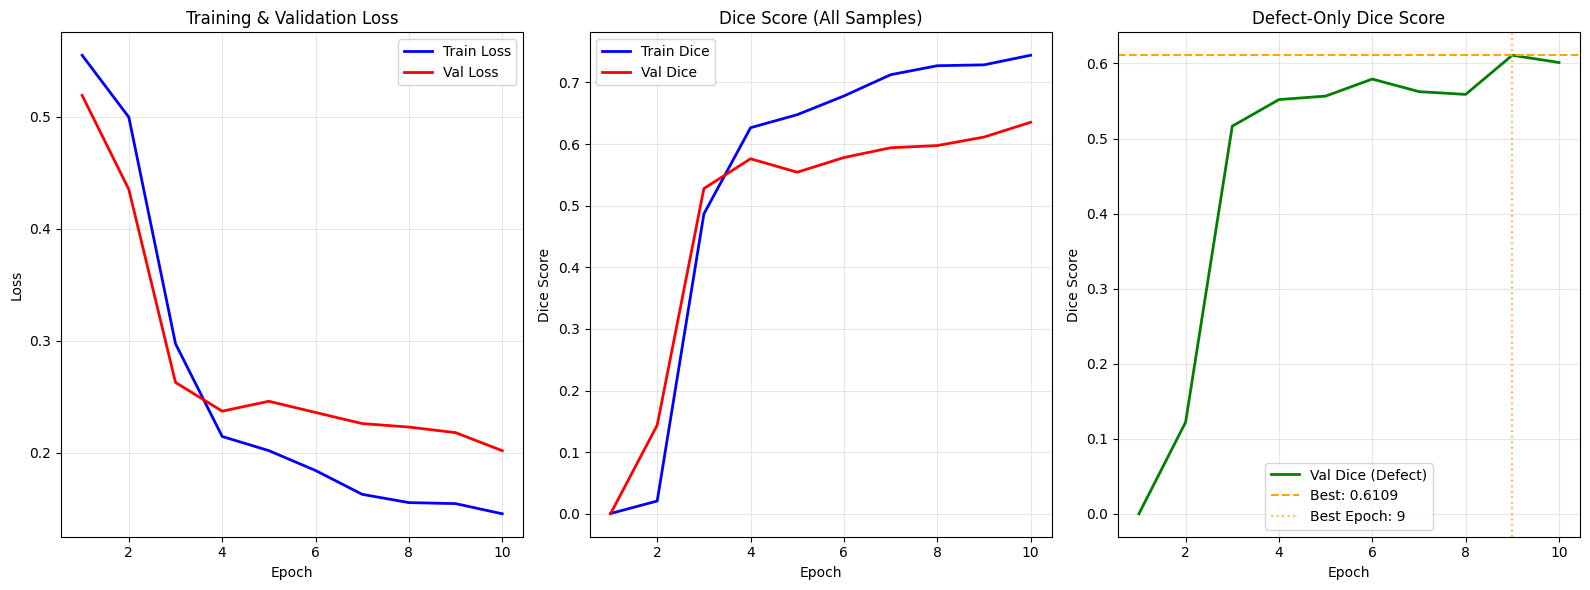

TRAINING SUMMARY
Final Train Loss: 0.1456
Final Val Loss: 0.2019
Final Val Dice (All): 0.6353
Final Val Dice (Defect): 0.6013
Best Val Dice (Defect): 0.6109
Best Epoch: 9


In [8]:
plot_training_history(
    v1_train_losses, 
    v1_val_losses, 
    v1_train_dices, 
    v1_val_dices, 
    v1_val_defect_dices
)

### Inference

In [9]:
def inference_test_set(model, test_loader, criterion, device, threshold=0.5):
    """Inference model on test set"""
    test_result = validate(
        model=model,
        loader=test_loader,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    print("TEST RESULTS")
    print("=" * 40)
    print(f"Test Loss: {test_result.loss:.4f}")
    print(f"Test Dice (All): {test_result.metrics_all.dice:.4f}")
    print(f"Test IoU (All): {test_result.metrics_all.iou:.4f}")
    print(f"Test Precision (All): {test_result.metrics_all.precision:.4f}")
    print(f"Test Recall (All): {test_result.metrics_all.recall:.4f}")
    print()
    print("DEFECT-ONLY METRICS")
    print("-" * 30)
    print(f"Test Dice (Defects): {test_result.metrics_defect_only.dice:.4f}")
    print(f"Test IoU (Defects): {test_result.metrics_defect_only.iou:.4f}")
    print(f"Test Precision (Defects): {test_result.metrics_defect_only.precision:.4f}")
    print(f"Test Recall (Defects): {test_result.metrics_defect_only.recall:.4f}")

    return test_result

def inference_visualize(model, test_loader, device, threshold=0.5, num_samples=8):
    """Model inference and visualization"""
    model.eval()

    # Get random samples from test set
    samples = []
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if len(samples) >= num_samples:
                break

            # Unpack 4 items: (images, masks, class_names, file_names)
            images, masks = batch[0], batch[1]
            images = images.to(device)
            masks = masks.to(device)

            # Model prediction
            outputs = model(images)
            preds = torch.sigmoid(outputs) > threshold

            # Convert to numpy for visualization
            for j in range(images.size(0)):
                if len(samples) >= num_samples:
                    break

                img = images[j].cpu().permute(1, 2, 0).numpy()
                true_mask = masks[j].cpu().squeeze().numpy()
                pred_mask = preds[j].cpu().squeeze().numpy()
                prob_map = torch.sigmoid(outputs[j]).cpu().squeeze().numpy()

                samples.append({
                    'image': img,
                    'true_mask': true_mask,
                    'pred_mask': pred_mask,
                    'prob_map': prob_map
                })

    # Visualization
    fig, axes = plt.subplots(4, num_samples, figsize=(3*num_samples, 12))

    for i, sample in enumerate(samples):
        # Original image
        axes[0, i].imshow(sample['image'])
        axes[0, i].set_title(f'Sample {i+1}')
        axes[0, i].axis('off')

        # Ground truth mask
        axes[1, i].imshow(sample['true_mask'], cmap='gray')
        axes[1, i].set_title('Ground Truth')
        axes[1, i].axis('off')

        # Prediction probability map
        axes[2, i].imshow(sample['prob_map'], cmap='hot', vmin=0, vmax=1)
        axes[2, i].set_title('Probability Map')
        axes[2, i].axis('off')

        # Binary prediction
        axes[3, i].imshow(sample['pred_mask'], cmap='gray')
        axes[3, i].set_title(f'Prediction (>{threshold})')
        axes[3, i].axis('off')

    plt.tight_layout()
    plt.show()

    return samples

TEST RESULTS
Test Loss: 0.1414
Test Dice (All): 0.7496
Test IoU (All): 0.6101
Test Precision (All): 0.7942
Test Recall (All): 0.7205

DEFECT-ONLY METRICS
------------------------------
Test Dice (Defects): 0.6030
Test IoU (Defects): 0.4762
Test Precision (Defects): 0.7085
Test Recall (Defects): 0.5911


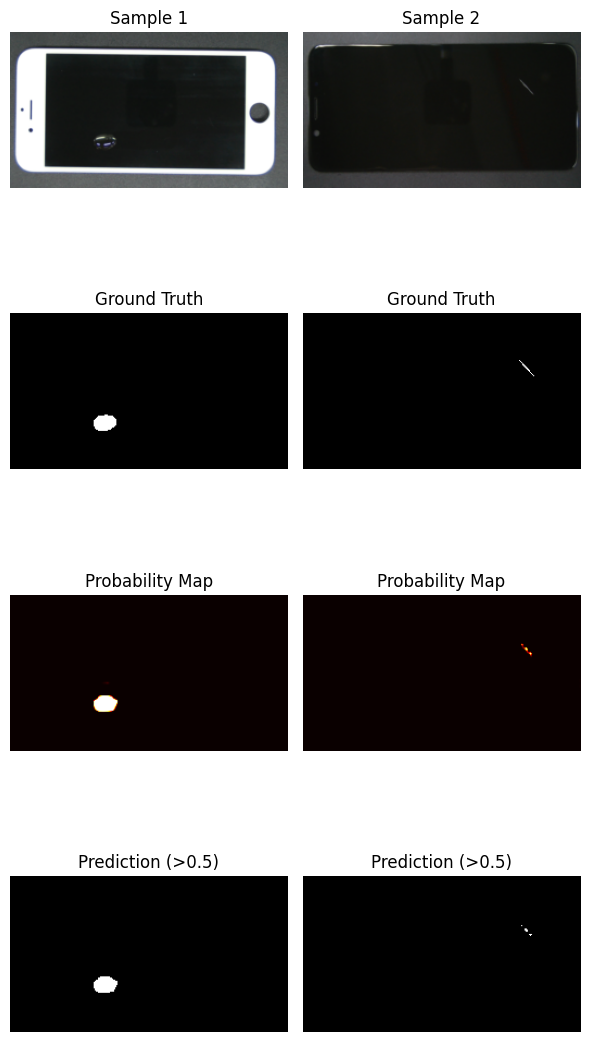

In [10]:
v1_test_result = inference_test_set(deeplabv1_model, test_loader, criterion, device, threshold=0.5)
v1_samples = inference_visualize(deeplabv1_model, test_loader, device, threshold=0.5, num_samples=2)

## DeepLabV2

In [11]:
from src.segtool.model import DeepLabv2

deeplabv2_model = DeepLabv2(
    in_channels=3,
    out_channels=1,
    base_channels=32,
    # dropout=0.1
).to(device)

v2_total_params = sum(p.numel() for p in deeplabv2_model.parameters())
v2_trainable_params = sum(p.numel() for p in deeplabv2_model.parameters() if p.requires_grad)
print(f"Total parameters: {v2_total_params:,}")
print(f"Trainable parameters: {v2_trainable_params:,}")

Total parameters: 188,769
Trainable parameters: 188,769


In [12]:
# optimizer
v2_optimizer = torch.optim.Adam(
    deeplabv2_model.parameters(),
    lr=1e-3,
    weight_decay=0.0
)

# loss function
criterion = BCEDiceLoss(bce_weight=0.5)  # BCE와 Dice Loss 조합

print(f"Device: {device}")
print(f"Model: {deeplabv2_model.__class__.__name__}")
print(f"Loss function: {criterion.__class__.__name__}")
print(f"Optimizer: {v2_optimizer.__class__.__name__}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Learning rate: {v2_optimizer.param_groups[0]['lr']}")
print(f"Dropout: {getattr(deeplabv2_model.dropout, 'p', 0.0)}")

Device: mps
Model: DeepLabv2
Loss function: BCEDiceLoss
Optimizer: Adam
Batch size: 8
Learning rate: 0.001
Dropout: 0.0


In [13]:
v2_train_losses = []
v2_val_losses = []
v2_train_dices = []
v2_val_dices = []
v2_val_defect_dices = []

epochs = 10
v2_best_val_dice = -1.0
threshold = 0.5

print(f"Starting DeepLabV2 Training for {epochs} epochs")
print("=" * 60)

# loop
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    # Training
    train_result = train_one_epoch(
        model=deeplabv2_model,
        loader=train_loader,
        optimizer=v2_optimizer,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    # Validation
    val_result = validate(
        model=deeplabv2_model,
        loader=val_loader,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    # 기록 저장
    v2_train_losses.append(train_result.loss)
    v2_val_losses.append(val_result.loss)
    v2_train_dices.append(train_result.metrics_all.dice)
    v2_val_dices.append(val_result.metrics_all.dice) # 모든 샘플에 대해 계산 (정상 포함)
    v2_val_defect_dices.append(val_result.metrics_defect_only.dice) # 결함이 있는 샘플만 계산

    # result
    print(f"Train - Loss: {train_result.loss:.4f} | Dice: {train_result.metrics_all.dice:.4f}")
    print(f"Val - Loss: {val_result.loss:.4f} | Dice: {val_result.metrics_all.dice:.4f} | Defect Dice: {val_result.metrics_defect_only.dice:.4f}")
    print("-" * 60)

    if val_result.metrics_defect_only.dice > v2_best_val_dice:
        v2_best_val_dice = val_result.metrics_defect_only.dice

print("\nDeepLabV2 Training completed!")
print(f"Best Validation Defect Dice: {v2_best_val_dice:.4f}")

Starting DeepLabV2 Training for 10 epochs
Epoch 1/10
Train - Loss: 0.5456 | Dice: 0.0004
Val - Loss: 0.5160 | Dice: 0.0000 | Defect Dice: 0.0000
------------------------------------------------------------
Epoch 2/10
Train - Loss: 0.5083 | Dice: 0.0172
Val - Loss: 0.5154 | Dice: 0.0000 | Defect Dice: 0.0000
------------------------------------------------------------
Epoch 3/10
Train - Loss: 0.4175 | Dice: 0.2549
Val - Loss: 0.3191 | Dice: 0.4490 | Defect Dice: 0.4442
------------------------------------------------------------
Epoch 4/10
Train - Loss: 0.2404 | Dice: 0.5825
Val - Loss: 0.2798 | Dice: 0.5130 | Defect Dice: 0.5153
------------------------------------------------------------
Epoch 5/10
Train - Loss: 0.2097 | Dice: 0.6357
Val - Loss: 0.3147 | Dice: 0.4250 | Defect Dice: 0.3845
------------------------------------------------------------
Epoch 6/10
Train - Loss: 0.1931 | Dice: 0.6618
Val - Loss: 0.2434 | Dice: 0.5611 | Defect Dice: 0.5202
-----------------------------------

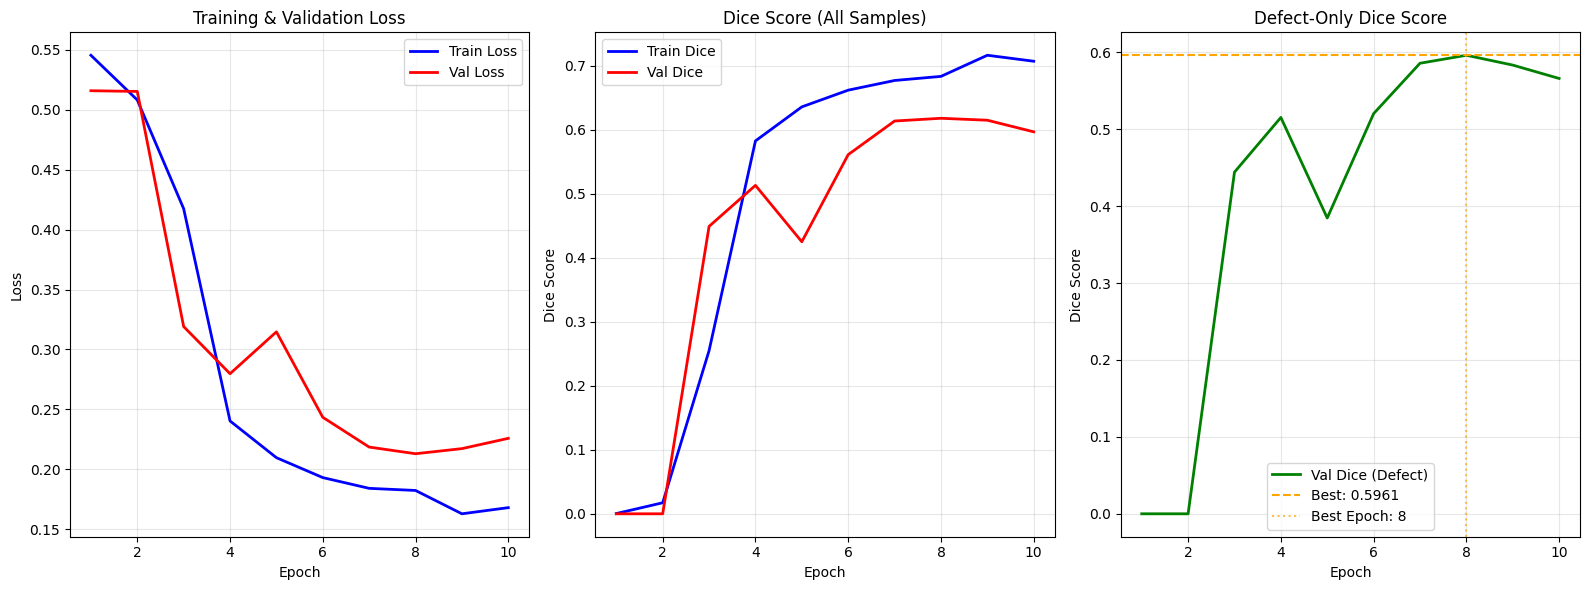

TRAINING SUMMARY
Final Train Loss: 0.1680
Final Val Loss: 0.2258
Final Val Dice (All): 0.5967
Final Val Dice (Defect): 0.5659
Best Val Dice (Defect): 0.5961
Best Epoch: 8


In [14]:
plot_training_history(
    v2_train_losses, 
    v2_val_losses, 
    v2_train_dices, 
    v2_val_dices, 
    v2_val_defect_dices
)

TEST RESULTS
Test Loss: 0.1864
Test Dice (All): 0.6751
Test IoU (All): 0.5336
Test Precision (All): 0.7632
Test Recall (All): 0.6202

DEFECT-ONLY METRICS
------------------------------
Test Dice (Defects): 0.5549
Test IoU (Defects): 0.4315
Test Precision (Defects): 0.7145
Test Recall (Defects): 0.5232


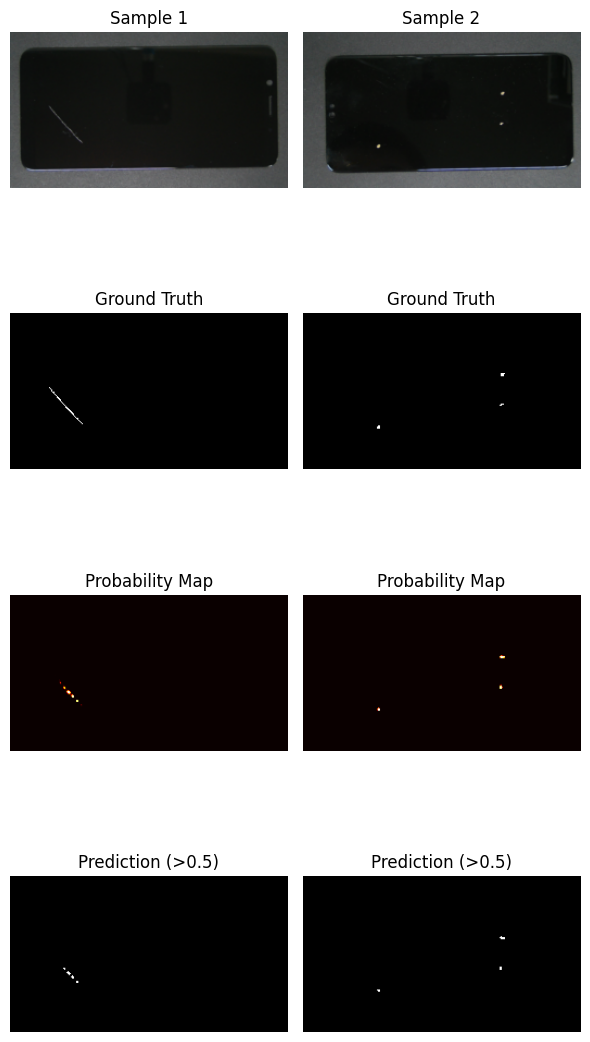

In [15]:
v2_test_result = inference_test_set(deeplabv2_model, test_loader, criterion, device, threshold=0.5)
v2_samples = inference_visualize(deeplabv2_model, test_loader, device, threshold=0.5, num_samples=2)

## DeepLabV3

In [16]:
from src.segtool.model import DeepLabv3

deeplabv3_model = DeepLabv3(
    in_channels=3,
    out_channels=1,
    base_channels=32,
    # dropout=0.1
).to(device)

v3_total_params = sum(p.numel() for p in deeplabv3_model.parameters())
v3_trainable_params = sum(p.numel() for p in deeplabv3_model.parameters() if p.requires_grad)
print(f"Total parameters: {v3_total_params:,}")
print(f"Trainable parameters: {v3_trainable_params:,}")

Total parameters: 205,281
Trainable parameters: 205,281


In [17]:
# optimizer
v3_optimizer = torch.optim.Adam(
    deeplabv3_model.parameters(),
    lr=1e-3,
    weight_decay=0.0
)

# loss function
criterion = BCEDiceLoss(bce_weight=0.5)

print(f"Device: {device}")
print(f"Model: {deeplabv3_model.__class__.__name__}")
print(f"Loss function: {criterion.__class__.__name__}")
print(f"Optimizer: {v3_optimizer.__class__.__name__}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Learning rate: {v3_optimizer.param_groups[0]['lr']}")
print(f"Dropout: {getattr(deeplabv3_model.dropout, 'p', 0.0)}")

Device: mps
Model: DeepLabv3
Loss function: BCEDiceLoss
Optimizer: Adam
Batch size: 8
Learning rate: 0.001
Dropout: 0.0


In [18]:
v3_train_losses = []
v3_val_losses = []
v3_train_dices = []
v3_val_dices = []
v3_val_defect_dices = []

epochs = 10
v3_best_val_dice = -1.0
threshold = 0.5

print(f"Starting DeepLabV3 Training for {epochs} epochs")
print("=" * 60)

# loop
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    # Training
    train_result = train_one_epoch(
        model=deeplabv3_model,
        loader=train_loader,
        optimizer=v3_optimizer,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    # Validation
    val_result = validate(
        model=deeplabv3_model,
        loader=val_loader,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    # 기록 저장
    v3_train_losses.append(train_result.loss)
    v3_val_losses.append(val_result.loss)
    v3_train_dices.append(train_result.metrics_all.dice)
    v3_val_dices.append(val_result.metrics_all.dice)
    v3_val_defect_dices.append(val_result.metrics_defect_only.dice)

    # result
    print(f"Train - Loss: {train_result.loss:.4f} | Dice: {train_result.metrics_all.dice:.4f}")
    print(f"Val - Loss: {val_result.loss:.4f} | Dice: {val_result.metrics_all.dice:.4f} | Defect Dice: {val_result.metrics_defect_only.dice:.4f}")
    print("-" * 60)

    if val_result.metrics_defect_only.dice > v3_best_val_dice:
        v3_best_val_dice = val_result.metrics_defect_only.dice

print("\nDeepLabV3 Training completed!")
print(f"Best Validation Defect Dice: {v3_best_val_dice:.4f}")

Starting DeepLabV3 Training for 10 epochs
Epoch 1/10
Train - Loss: 0.5441 | Dice: 0.0004
Val - Loss: 0.5160 | Dice: 0.0000 | Defect Dice: 0.0000
------------------------------------------------------------
Epoch 2/10
Train - Loss: 0.3826 | Dice: 0.2841
Val - Loss: 0.2574 | Dice: 0.5419 | Defect Dice: 0.5137
------------------------------------------------------------
Epoch 3/10
Train - Loss: 0.2123 | Dice: 0.6285
Val - Loss: 0.2472 | Dice: 0.5614 | Defect Dice: 0.5453
------------------------------------------------------------
Epoch 4/10
Train - Loss: 0.1941 | Dice: 0.6612
Val - Loss: 0.2381 | Dice: 0.5729 | Defect Dice: 0.5430
------------------------------------------------------------
Epoch 5/10
Train - Loss: 0.1924 | Dice: 0.6658
Val - Loss: 0.2232 | Dice: 0.6046 | Defect Dice: 0.5820
------------------------------------------------------------
Epoch 6/10
Train - Loss: 0.1779 | Dice: 0.6874
Val - Loss: 0.2613 | Dice: 0.5362 | Defect Dice: 0.5465
-----------------------------------

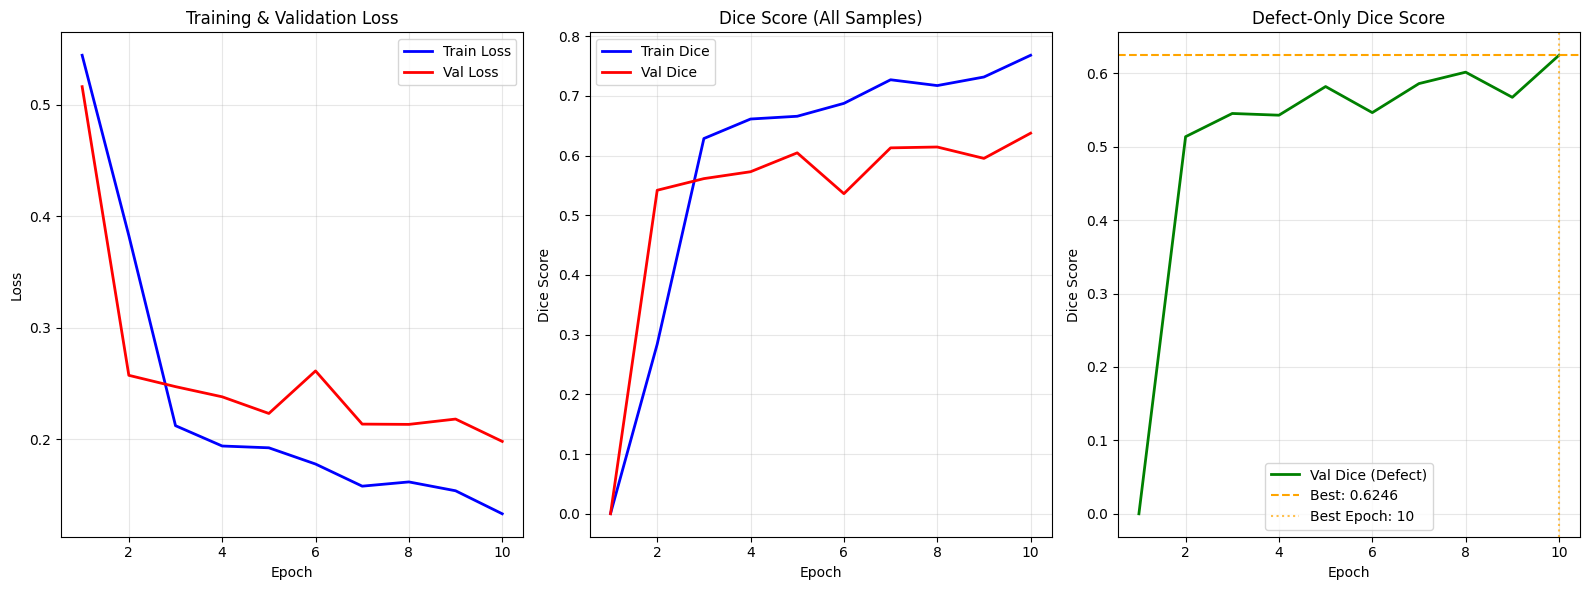

TRAINING SUMMARY
Final Train Loss: 0.1333
Final Val Loss: 0.1982
Final Val Dice (All): 0.6375
Final Val Dice (Defect): 0.6246
Best Val Dice (Defect): 0.6246
Best Epoch: 10


In [19]:
plot_training_history(
    v3_train_losses, 
    v3_val_losses, 
    v3_train_dices, 
    v3_val_dices, 
    v3_val_defect_dices
)

TEST RESULTS
Test Loss: 0.1417
Test Dice (All): 0.7488
Test IoU (All): 0.6042
Test Precision (All): 0.7187
Test Recall (All): 0.8006

DEFECT-ONLY METRICS
------------------------------
Test Dice (Defects): 0.6156
Test IoU (Defects): 0.4841
Test Precision (Defects): 0.5891
Test Recall (Defects): 0.7402


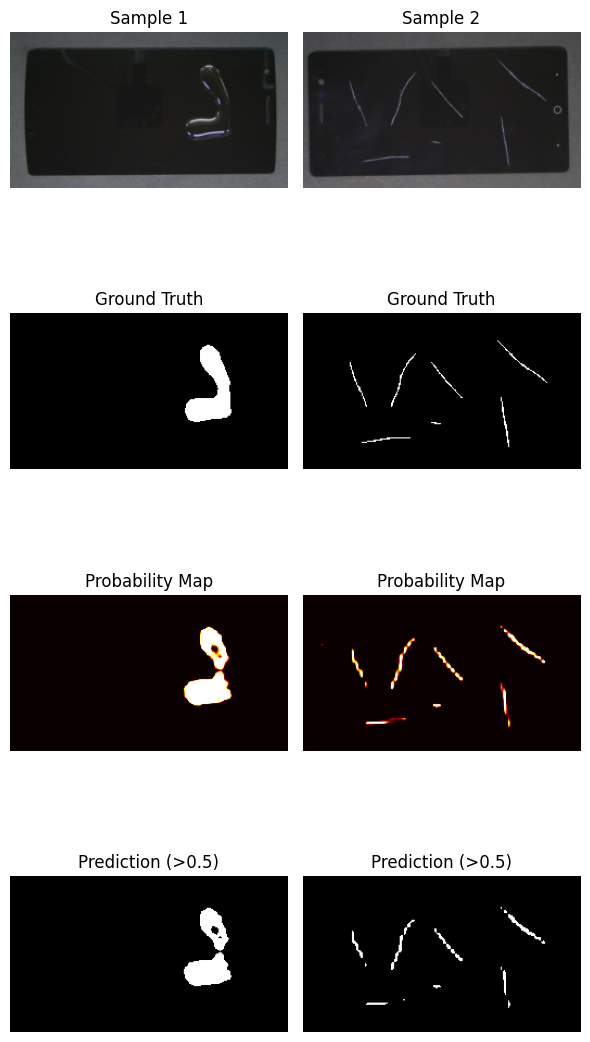

In [20]:
v3_test_result = inference_test_set(deeplabv3_model, test_loader, criterion, device, threshold=0.5)
v3_samples = inference_visualize(deeplabv3_model, test_loader, device, threshold=0.5, num_samples=2)

## Model Comparison

In [21]:
comparison_df = pd.DataFrame({
    'Model': ['DeepLabV1', 'DeepLabV2', 'DeepLabV3'],
    'Best_Val_Dice': [v1_best_val_dice, v2_best_val_dice, v3_best_val_dice],
    'Parameters': [v1_total_params, v2_total_params, v3_total_params],
    'Test_Dice': [
        v1_test_result.metrics_defect_only.dice,  # V1 test result
        v2_test_result.metrics_defect_only.dice,  # V2 test result
        v3_test_result.metrics_defect_only.dice  # V3 test result
    ]
})
comparison_df

,Model,Best_Val_Dice,Parameters,Test_Dice
0,DeepLabV1,0.610933,139489,0.602962
1,DeepLabV2,0.596088,188769,0.554946
2,DeepLabV3,0.624600,205281,0.615631


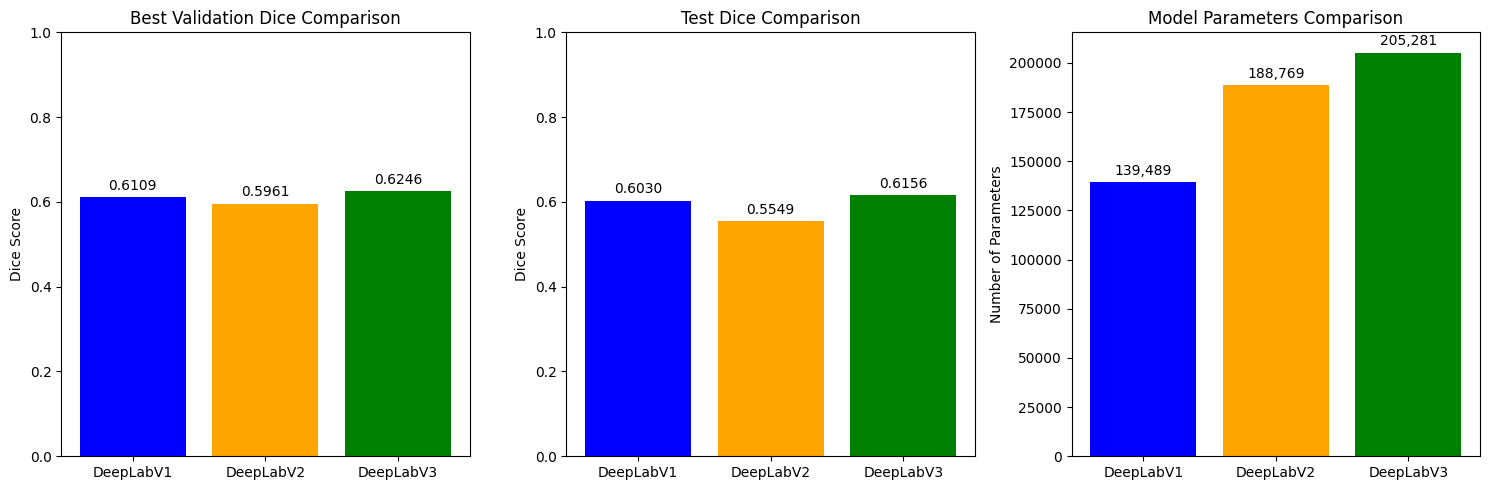


Best Validation Performance: DeepLabV3
Best Test Performance: DeepLabV3
Most Efficient (Parameters): DeepLabV1


In [22]:
# 시각화
plt.figure(figsize=(15, 5))

# 1. Best Validation Dice 비교
plt.subplot(1, 3, 1)
plt.bar(comparison_df['Model'], comparison_df['Best_Val_Dice'], color=['blue', 'orange', 'green'])
plt.title('Best Validation Dice Comparison')
plt.ylabel('Dice Score')
plt.ylim(0, 1)
for i, v in enumerate(comparison_df['Best_Val_Dice']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# 2. Test Dice 비교
plt.subplot(1, 3, 2)
plt.bar(comparison_df['Model'], comparison_df['Test_Dice'], color=['blue', 'orange', 'green'])
plt.title('Test Dice Comparison')
plt.ylabel('Dice Score')
plt.ylim(0, 1)
for i, v in enumerate(comparison_df['Test_Dice']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# 3. 파라미터 수 비교
plt.subplot(1, 3, 3)
plt.bar(comparison_df['Model'], comparison_df['Parameters'], color=['blue', 'orange', 'green'])
plt.title('Model Parameters Comparison')
plt.ylabel('Number of Parameters')
for i, v in enumerate(comparison_df['Parameters']):
    plt.text(i, v + max(comparison_df['Parameters'])*0.01, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Best model 찾기
best_val_model = comparison_df.loc[comparison_df['Best_Val_Dice'].idxmax(), 'Model']
best_test_model = comparison_df.loc[comparison_df['Test_Dice'].idxmax(), 'Model']

print(f"\nBest Validation Performance: {best_val_model}")
print(f"Best Test Performance: {best_test_model}")
print(f"Most Efficient (Parameters): {comparison_df.loc[comparison_df['Parameters'].idxmin(), 'Model']}")